In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

import timeit



plt.rc('font', size=20)

In [2]:
class AbstractOneStepODESolver:
    
    def __init__(self, n, f, u0, numBlocks, tStart, tEnd, matrix): # or set dt instead?
        
        
        self.f = f
        self.u0 = u0
        self.n = n
        self.matrix = matrix
       
        self.numBlocks, self.numPoints = numBlocks, numBlocks + 1
        self.dt = (float(tEnd) - float(tStart))/float(self.numBlocks)
        
        self.solutionArray = np.zeros((self.numPoints, self.n)) # TODO: check order
        self.timeArray = np.linspace(tStart, tEnd, self.numPoints)
        
        self.tStart, self.tEnd = float(tStart), float(tEnd)
        
        self.plotStyle = None
        
        print('Object of class ' + self.__class__.__name__ + ' is created.')
        
  
    def Solve(self):
        
        print('Begin calculations using %s ...' % self.__class__.__name__)
        start = timeit.default_timer()
        
        self.solutionArray[0] = self.u0
        
        # timestepping
        for i in range(self.numBlocks):
                                
            # step
            self.solutionArray[i + 1] = self._AdvanceNextStep(i)
            
            # printing out the progress
            if ((i + 1) % (self.numBlocks//10) == 0):
                t = self.timeArray[i + 1]
                print('%d%% calculations completed' % (100.*float(t)/(self.tEnd - self.tStart)) )
                
            
            
        elapsedTime = float(timeit.default_timer() - start)
        print('Time elapsed: %.2e s.' % elapsedTime)
    
    
    def _AdvanceNextStep(self, i):
        
        raise NotImplementedError # TODO: ()?

    
    def PlotSolution(self, isFirst, isLast):
        if isFirst:
            plt.figure(figsize=(11,7))
            xData4Exact = np.linspace(self.tStart, self.tEnd, 500)
            plt.plot(xData4Exact, self.Exact(xData4Exact), 'k--', marker=None, lw=3, label='Exact')
        
        marker_ = 'o'
        if (self.numBlocks > 30):
            marker_ = None
        
        plt.plot(self.timeArray, self.solutionArray[:,0], '-', marker=marker_, lw=2, label=self.__class__.__name__)
        #plt.grid('off')
        plt.title('dx = %.2e' % self.dt)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()

        if isLast:            
            plt.show()

    
    def Exact(self, x):
        # obtained via WolframAlpha
        return -1./12 * np.exp(-3*x) * x * (129*(x**3) + 16*(x**2) - 54*x - 36)


In [3]:
class ForwardEuler(AbstractOneStepODESolver):

    def _AdvanceNextStep(self, i):
        # for short
        uOld, dt, f = self.solutionArray[i], self.dt, self.f
        
        # Forward Euler formula
        uNew = uOld + dt*f(uOld)
        
        return uNew


class RK4(AbstractOneStepODESolver):

    def _AdvanceNextStep(self, i):
    
        uOld, dt, f = self.solutionArray[i], self.dt, self.f
        
        k1 = f(uOld)
        k2 = f(uOld + dt/2.*k1)
        k3 = f(uOld + dt/2.*k2)
        k4 = f(uOld + dt*k3)
            
        uNew = uOld + dt/6. * (k1 + 2.*k2 + 2.*k3 + k4)

        return uNew


class BackwardEuler(AbstractOneStepODESolver):
    
    def _AdvanceNextStep(self, i):
    
        uOld, dt, f = self.solutionArray[i], self.dt, self.f

        # solving SLAE
        uNew = scipy.linalg.solve(np.eye(self.n) - dt*np.array(self.matrix), uOld)

        return uNew

In [4]:
odeCoeffs1 = [1, 15, 90, 270, 405, 243]

class rhsLinear:

    def __init__(self, n, odeCoeffs):
        self.A = np.zeros((n, n))

        ### initializing non-zero matrix entries
        # setting upper-diag entries
        for i in range(n - 1):
            self.A[i, i + 1] = 1.
        
        # setting the last row
        for i in range(n):
            self.A[n - 1, i] = -1.*odeCoeffs[n - i] # TODO
        
        
        print(self.A)
        

    def __call__(self, u):
        # implements A*u
        return self.A.dot(u)

In [5]:
# stiffness evaluation
rhs1 = rhsLinear(n=len(odeCoeffs1) - 1, odeCoeffs=odeCoeffs1)

eigenvals = scipy.linalg.eigvals(rhs1.A)


arg_ = np.abs(np.real(eigenvals))
stiffnessCoeff = np.max( arg_ ) / np.min( arg_ )

print('Stiffness coefficient: %.5e' % stiffnessCoeff)

[[   0.    1.    0.    0.    0.]
 [   0.    0.    1.    0.    0.]
 [   0.    0.    0.    1.    0.]
 [   0.    0.    0.    0.    1.]
 [-243. -405. -270.  -90.  -15.]]
Stiffness coefficient: 1.00205e+00


Object of class RK4 is created.
Begin calculations using RK4 ...
10% calculations completed
20% calculations completed
30% calculations completed
40% calculations completed
50% calculations completed
60% calculations completed
70% calculations completed
80% calculations completed
90% calculations completed
100% calculations completed
Time elapsed: 1.71e-02 s.
Object of class ForwardEuler is created.
Begin calculations using ForwardEuler ...
10% calculations completed
20% calculations completed
30% calculations completed
40% calculations completed
50% calculations completed
60% calculations completed
70% calculations completed
80% calculations completed
90% calculations completed
100% calculations completed
Time elapsed: 2.74e-03 s.
Object of class BackwardEuler is created.
Begin calculations using BackwardEuler ...
10% calculations completed
20% calculations completed
30% calculations completed
40% calculations completed
50% calculations completed
60% calculations completed
70% calcula

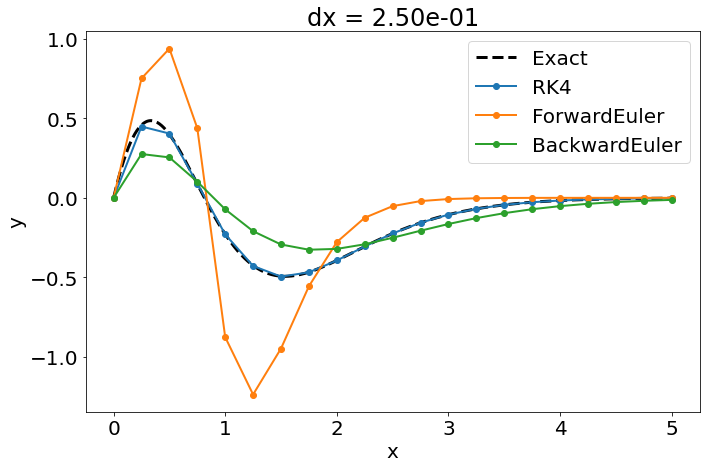

In [6]:
# main
methods = [RK4, ForwardEuler, BackwardEuler]
counter = 0

for method in methods:
    # calling the constructor
    method = method(n=len(odeCoeffs1) - 1, f=rhs1, u0=[0., 3., -9., -8., 0.], numBlocks=20, tStart=0., tEnd=5., \
                                                            matrix=rhs1.A)
    
    method.Solve()
    method.PlotSolution(isFirst=(counter == 0), isLast=(counter == len(methods)))

    counter += 1

Object of class RK4 is created.
Begin calculations using RK4 ...
10% calculations completed
20% calculations completed
30% calculations completed
40% calculations completed
50% calculations completed
60% calculations completed
70% calculations completed
80% calculations completed
90% calculations completed
100% calculations completed
Time elapsed: 1.13e-02 s.


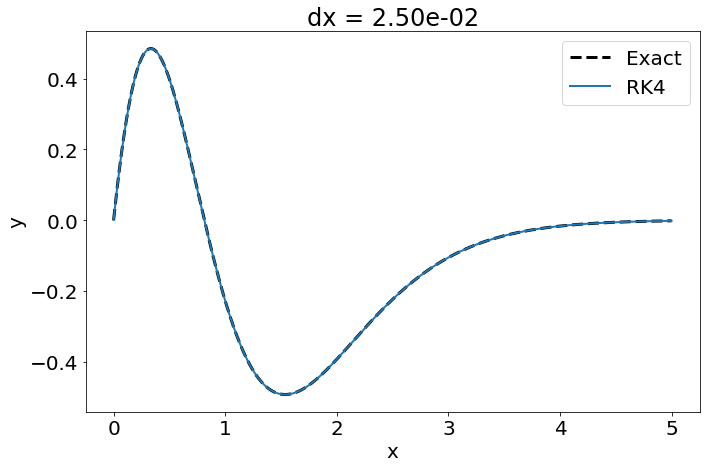

In [7]:
# calculating num solution using an implicit method and small dx
# calling the constructor
method = RK4(n=len(odeCoeffs1) - 1, f=rhs1, u0=[0., 3., -9., -8., 0.], numBlocks=200, tStart=0., tEnd=5., \
                                                            matrix=rhs1.A)
    
method.Solve()
method.PlotSolution(isFirst=1, isLast=0)